[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/yue-sun/generative-art/blob/main/03_wednesday/02_physical_oscillators.ipynb)

# Continuous Physical Systems for Swarming and Synchronization

![swarm.gif](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/swarmalator_header.gif)

As we gradually relax the discrete properties of our physical systems to continuous ones, the next model we will look at is the two-dimensional [**Kuramoto model**](https://en.wikipedia.org/wiki/Kuramoto_model) of interacting oscillators. This is a system designed to model synchronization, such as of circadian systems of plants and animations. We will simulate three variations of the Kuramoto model:
- A basic version where oscillators are fixed in space
- A generalized version (also known as the _Swarmalator_ model) where oscillators can move freely in space
- An even more generalized version with additional external forces

Much like the cells in our cellular automata, here we consider a lattice of oscillators which interact with one another. However, rather than assigning a binary state, $0$ or $1$, each oscillator carries a continuous state - _a phase_ - which varies from $0$ to $2\pi$. These phases evolve continuously in time, governed by an ordinary differential equation (ODE) which prescribes their evolution based on nearest-neighbor interactions.

![swarm.gif](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/ca_vs_kuramoto.png)

We will follow the same numerical integration approach to simulate the Kuramoto models:

0. import libraries
1. set physical and simulation parameters
2. initialize variables (e.g. phase and/or positions of oscillators)
3. define a function for the ODE
4. numerically integrate with `solve_ivp`

In visualizations, we will color each oscillators with an RGB value corresponding to its phase, i.e. colors represent phases.

## A basic Kuramoto model (fixed in space)

First, let us import some necessary libraries.

In [1]:
import numpy as np
from numba import njit # enable compiling for speedup
from scipy.integrate import solve_ivp
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import ipywidgets as widgets
from IPython.display import HTML, display

Before we delve into the mathematical model, let us write a function to randomly initialize a $N\times N$ lattice of such oscillators, with random phases in the range $[0,2\pi)$.
> Note: The `numpy` function `np.random.rand(N,N)` will return an $N\times N$ array of random numbers in the range $[0,1)$ and `np.pi` returns the value of $\pi$.

In [2]:
def init_kuramoto(N, seed):
    ''' Initialize an NxN lattice of oscillators with random phases.'''
    # Set random seed
    np.random.seed(seed)
    # Create lattice
    lat = 2*np.pi * np.random.rand(N, N)
    return lat

Next, we need to create helper functions for plotting and animation.

In [3]:
def plot_kuramoto(theta, colormap='hsv'):
    ''' Plot a single snapshot of the Kuramoto model via
        a lattice of oscillators (phases) as a colored image.
        Inputs:
            theta - the array of oscillator phases
            colormap - an optional specification for a colormap to use
        Outputs:
            fig, ax, im - handles to figure, axis, and image
    '''
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    colors = get_colors(theta, colormap)
    im = ax.imshow(colors, extent=[-1,1,-1,1])
    ax.tick_params(labelsize=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    ax.grid(False)
    fig.tight_layout()

    return fig, ax, im

def animate_kuramoto(out, colormap='hsv'):
    ''' Animate the Kuramoto model over time.
        Inputs:
            out - 3D array of frames
            colormap - an optional specification for a colormap to use
        Outputs:
            ani - handle to animation
    '''
    frames = out.shape[-1]
    fig, ax, im = plot_kuramoto(out[:,:,0], colormap);

    def animate(i):
        ''' Plot updates for animation.'''
        colors = get_colors(out[:,:,i], colormap)
        im.set_data(colors)
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return ani

def get_colors(theta, colormap='hsv'):
    ''' Calculate RGB colors from a matplotlib colormap by
        mapping an array of periodic values (0 to 2*pi) to
        RGBA color channels of a matplotlib colormap.
        Inputs:
            theta - the array of values
            colormap - the name of the colormap to use
        Outputs:
            colors - RGB colors
    '''
    theta = np.mod(theta, 2*np.pi)         # shift all theta to [0,2*pi], since all values are cyclic
    norm = Normalize(vmin=0., vmax=2*np.pi) # set the color range from [0,2*pi]
    cmap = plt.get_cmap(colormap)           # get the colormap object
    colors = cmap(norm(theta))              # evaluate the colormap to get color channels (RGBA)
    colors[..., -1] = 0.8                   # change the opacity
    return colors

Let us test these helper functions by creating a system of $100\times100$ oscillators.

In [ ]:
# Set parameters
N = 100   # lattice size
seed = 12 # random seed

# Generate the random lattice
lat = init_kuramoto(N, seed)

# Plot initial snapshot
plot_kuramoto(lat);

The ordinary differential equation (ODE) governs the evolution of each oscillator's phase $\theta_i$ is given by:
$$
\frac{d\theta_i}{dt} = \omega + K\sum_{j\in N(i)}\sin(\theta_j-\theta_i)
$$
where $\omega$ is a constant angular velocity, and $K$ is a global coupling strength between neighbors. The sum is performed over all oscillators $j$ in the neighborhood $N(i)$ of oscillator $i$:

![swarm.gif](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/kuramoto_kernel.png)

Our goal here is to define a function that takes its inputs ($t$, all $\theta_i$, and $K$), and returns an array $d\theta_i/dt$. Since the ODE involves a sum over discrete neighbors, we could use discrete convolution to perform this sum. However, in its current form, $\sum_{j\in N(i)}\sin(\theta_j-\theta_i)$ cannot be carried out by convolution since $\theta_j$ is coupled with $\theta_i$ in a nonlinear function. So what can we do?

Trigonometric identity comes to the rescue! Let us try:
$$
\sin(a-b) = \sin(a)\cos(b) - \cos(a)\sin(b)
$$
to rewrite the above summation to
$$
\sum_{j\in N(i)}\sin(\theta_j-\theta_i) = \cos(\theta_i)\sum_{j\in N(i)}\sin(\theta_j) - \sin(\theta_i)\sum_{j\in N(i)}\cos(\theta_j)
$$
given $\theta_i$ is a constant with respect to (w.r.t.) the summation and can be pulled out. Now we can perform our convolution! While each of the two summations is not linear in $\theta_i$ and $\theta_j$, it *is* linear in their individual trigonometric transformations $\sin(\theta_i)$ and $\sin(\theta_j)$ (and $\cos(\theta_i)$ and $\cos(\theta_j)$).

To make our code more generalizable, we add two small extensions to the ODE by introducing a constant phase shift $\alpha$ between $\theta_i$ and $\theta_j$, and a variable coupling strength $a_{ij}$:
$$
\frac{d\theta_i}{dt} = \omega + K\sum_{j\in N(i)}a_{ij}\sin(\theta_j-\theta_i-\alpha)
$$
Grouping $\theta_i$ and $\alpha$ together and performing the trigonometric identity again, we can rewrite this updated ODE in a convolution-friendly form:
$$
\boxed{
\frac{d\theta_i}{dt} = \omega + K\cos(\theta_i+\alpha)\sum_{j\in N(i)}a_{ij}\sin(\theta_j) - K\sin(\theta_i+\alpha)\sum_{j\in N(i)}a_{ij}\cos(\theta_j)
}
$$

We implemented the ODE in the function `kuramoto` below. We will start with a von Neumann neighborhood of range $r=2$, which corresponds to the convolution kernel:
$$
\begin{bmatrix}
0 & 0 & 1 & 0 & 0 \\
0 & 1 & 1 & 1 & 0 \\
1 & 1 & 0 & 1 & 1 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 
\end{bmatrix}
$$
with $a_{ij}=1$ for all $j\in N(i)$. Notice that the center cell is $0$, as only the neighbors contribute to the summation.

In [4]:
def kuramoto(t, theta, N, w, K, alpha, kernel):
    ''' ODE for the Kuramoto oscillator system.
        Inputs:
            t - the current time
            theta - a flattened array of oscillator phases
            N - the system size in each dimension
            w - the constant angular velocity
            K - the global coupling strength
            alpha - the phase shift
        Outputs:
            dtheta - a flattened array of first derivatives of theta
    '''
    theta = theta.reshape(N, N) # reshape into square format for convolution
    sth = np.sin(theta)
    cth = np.cos(theta)
    sum_sth = convolve2d(sth, kernel, mode='same',
                         boundary='wrap') # periodic boundary conditions
    sum_cth = convolve2d(cth, kernel, mode='same',
                         boundary='wrap') # periodic boundary conditions

    # Define the first derivative and return the flattened array
    dtheta = w + K*np.cos(theta+alpha)*sum_sth - K*np.sin(theta+alpha)*sum_cth
    return dtheta.ravel()

Finally, the wrapper function `solve_kuramoto` below integrates the ODE using the function `solve_ivp` from the Python `scipy` library.

In [5]:
def solve_kuramoto(func, ti, tf, nt, thetai, args, rtol=1e-6, atol=1e-6):
    ''' Integrates the Kuramoto model.
        Inputs:
            func - the function to integrate
            ti, tf - start and end integration times
            nt - number of evenly spaced output time points in [ti, tf]
            yi - initial concentrations [u, v]
            args - tuples of model parameters
            rtol, atol - tolerance for tuning the accuracy of the solver
        Outputs:
            theta - the current theta at the end time
    '''
    N = args[0]                              # extract grid dimension
    t_eval = np.linspace(ti, tf, nt)         # evaluation time points

    # Integrate the differential equation using finite differences (default RK45)
    sol = solve_ivp(lambda t, y: func(t, y, *args), t_span=[ti, tf],
                    y0=thetai.ravel(), t_eval=t_eval, rtol=rtol, atol=atol)
    theta = sol.y.reshape(N, N, len(t_eval)) # collection of all theta snapshots

    return theta

Let us test our Kuramoto simulation.

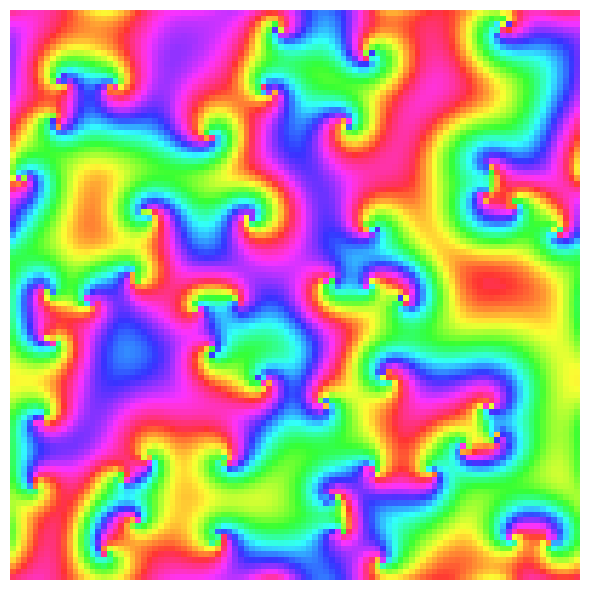

In [6]:
# Set model parameters
N = 100      # system size
alpha = 0.6  # phase shift
w = 0.5      # angular velocity
K = 0.2      # global coupling strength

ti = 0       # start time
tf = 60      # end time
frames = 120 # number of output time points

# Convolution kernel to test: von Neumann neighborhood of radius 2
kernel = np.array([[0, 0, 1, 0, 0],
                   [0, 1, 1, 1, 0],
                   [1, 1, 0, 1, 1],
                   [0, 1, 1, 1, 0],
                   [0, 0, 1, 0, 0]])

# Solve and plot final snapshot
lat = init_kuramoto(N, seed=12)
out = solve_kuramoto(kuramoto, ti, tf, frames, lat, args=(N, w, K, alpha, kernel))
plot_kuramoto(out[:,:,-1]);

And animate our outputs!

In [ ]:
# Create and display animation
ani = animate_kuramoto(out, colormap='hsv')
HTML(ani.to_html5_video())

In [ ]:
# Save animation as a gif
ani.save('kuramoto.gif', writer='pillow', fps=20)

We can also test what happens when the coupling strengths $a_{ij}$ vary. We use the following convolution kernel:
$$
\begin{bmatrix}
0 & 0 & -1 & 0 & 0 \\
0 & 0 & 4 & 0 & 0 \\
-1 & 4 & -12 & 4 & -1 \\
0 & 0 & 4 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 
\end{bmatrix}
$$
which is a discrete approximation of the biharmonic operator:
$$
-\nabla^4=-\dfrac{\partial^4}{\partial x^4}-\dfrac{\partial^4}{\partial y^4}
$$
often appeared in linear elasticity theory and solutions to the Stokes flows.

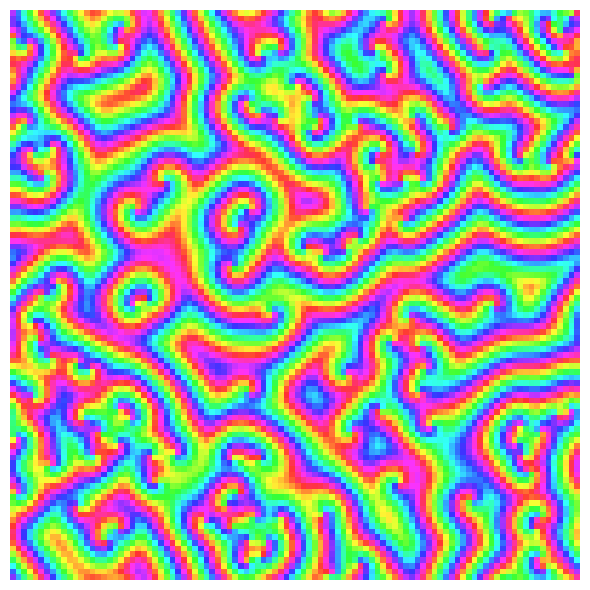

In [7]:
# Set model parameters
N = 100      # system size
alpha = 0.6  # phase shift
w = 0.0      # angular velocity
K = 1.0      # global coupling strength

ti = 0       # start time
tf = 120     # end time
frames = 240 # number of output time points

# Convolution kernel to test: von Neumann neighborhood of radius 2
kernel = np.array([[0,  0,  -1, 0,  0],
                   [0,  0,   4, 0,  0],
                   [-1, 4, -12, 4, -1],
                   [0,  0,   4, 0,  0],
                   [0,  0,  -1, 0,  0]])

# Solve and plot final snapshot
lat = init_kuramoto(N, seed=12)
out = solve_kuramoto(kuramoto, ti, tf, frames, lat, args=(N, w, K, alpha, kernel))
plot_kuramoto(out[:,:,-1]);

In [ ]:
# Create and display animation
ani = animate_kuramoto(out, colormap='hsv')
HTML(ani.to_html5_video())

We can see that the effect of this new kernel makes the phase correlations more short-ranged, as closer neighbors couple more strongly.

In [ ]:
# Save animation as a gif
ani.save('kuramoto.gif', writer='pillow', fps=20)

## A generalized Kuramoto model (free in space) 

Next, let us examine what happens if we allow our oscillators to move freely in space. Such systems exhibit _spatial_ self-organization, much like swarms of insects or flocks of birds. The example presented here is based on the following paper:
>O’Keeffe, K.P., Hong, H. & Strogatz, S.H. Oscillators that sync and swarm. Nat Commun 8, 1504 (2017) doi:10.1038/s41467-017-01190-3 https://www.nature.com/articles/s41467-017-01190-3.

![swarm.gif](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/ca_vs_swarmalator.png)

Not only are the oscillators free to move continuously in 2D space, their interactions are no longer limited to nearest neighbors, but are long-ranged. We will see that this model system has interesting analogues to the concept of phases and phase separation in physics, while maintaining the notion of continuous states (or phases) or each oscillators. Due to the collective swarm-like behaviors of these oscillators, as well as the oscillatory nature of their internal states, the authors name such agents "swarmalators".

Again, let us first write a function to randomly initialize our swarmalator positions in a square $[-1,1]\times[-1,1]$, with random phases in the range $[0,2\pi)$, before we start building the Swarmalator model.

In [8]:
def init_swarm(N, seed):
    ''' Initialize N swarmalators in [-1,1]x[-1,1] with random phases.
        Inputs:
            N - number of swarmalators
            seed - random seed
        Outputs:
            x - initial x-coordinates of the swarmalators
            y - initial y-coordinates of the swarmalators
            phase - initial phases of the swarmalators
    '''
    # Set random seed
    np.random.seed(seed)
    # Create positions and phases
    x = 2*np.random.rand(N) - 1.
    y = 2*np.random.rand(N) - 1.
    phase = 2*np.pi * np.random.rand(N)
    return x, y, phase

We also create helper functions for plotting and animation.

In [9]:
def plot_swarm(x, y, theta, colormap='hsv'):
    ''' Plot swarmalators in 2D with phases represented by color.
        Inputs:
            x - the x-coordinates of the swarmalators
            y - the y-coordinates of the swarmalators
            theta - the phases pf the swarmalators
            colormap - an optional specification for a colormap to use
        Outputs:
            fig, ax, im - handles to figure, axis, and image
    '''
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    colors = get_colors(theta, colormap)
    im = ax.scatter(x, y, color=colors, s=110)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()

    return fig, ax, im

def animate_swarm(out, colormap='hsv'):
    ''' Animate the Swarmalator model over time.
        Inputs:
            out - 3D array of frames
            colormap - an optional specification for a colormap to use
        Outputs:
            ani - handle to animation
    '''
    frames = out.shape[-1]
    x, y, theta = out[0,:,0], out[1,:,0], out[2,:,0]
    fig, ax, im = plot_swarm(x, y, theta, colormap);

    def animate(i):
        ''' Plot updates for animation.'''
        x, y, theta = out[0,:,i], out[1,:,i], out[2,:,i]
        im.set_offsets(np.stack((x,y), axis=-1))
        colors = get_colors(theta, colormap)
        im._facecolors = colors
        im._edgecolors = colors
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return ani

Now, let us visualize an initial population of $N=200$ swarmalators.

In [ ]:
# Set parameters
N = 200   # number of swarmalators
seed = 12 # random seed

# Initialize the swarmalators
x, y, theta = init_swarm(N, seed)

# Plot initial snapshot
plot_swarm(x, y, theta);

The evolution of the swarmalators in time is governed by a set of ODEs which prescribe the agent's motion in space, in addition to the phase evolution we have examined before. We will consider a particular case of the model:
$$
\begin{aligned}
\frac{dx_i}{dt} &= u_i + \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{x_j-x_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{x_j-x_i}{r^2_{ij}}\Bigg) \\
\frac{dy_i}{dt} &= v_i + \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{y_j-y_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{y_j-y_i}{r_{ij}^2}\Bigg) \\
\frac{d\theta_i}{dt} &= \omega_i + \frac{K}{N}\sum_{j\neq{i}}^N\frac{\sin(\theta_j-\theta_i)}{r_{ij}}
\end{aligned}
$$
where $N$ is the total number of swarmalators, $r_{ij}=\sqrt{\left(x_j-x_i\right)^2+\left(y_j-y_i\right)^2}$ is the distance between two swarmalators, $u_i$ and $v_i$ are the constant velocity in x and y coordinates, and $\omega_i$ is the constant angular velocity. Note that $u_i$, $v_i$ and $\omega_i$ can be individually controlled for each agent. $J$ and $K$ are model parameters:
- $J$ tunes the influence of phase on spatial proximity
- $K$ adjusts the phases interaction

The first term in the expressions for $dx_i/dt$ and $dy_i/dt$ captures the spatially attractive interaction between swarmalators, and the second term a repulsive one. What are some preliminary conclusions we can draw about the model based on these equations?

For simplicity, we assume $u_i=v_i=\omega_i=0$ for all agents. Let us define the ODEs in the function `swarmalator`.

In [10]:
@njit
def swarm(t, q, N, J, K):
    ''' ODE for the Swarmalator system.
        Inputs:
            t - the current time
            q - a flattened array of the current x, y, and theta
            N - the number of swarmalators
            J - coupling constant (influence of phase on spatial rearrangement)
            K - coupling constant (phase–phase interaction)
        Outputs:
            dq - a flattened array of first derivatives of x, y, and theta
    '''
    # Unpack the x-coordinates, y-coordinates, and phases
    x, y, theta = q[:N], q[N:2*N], q[2*N:]

    # Set up arrays to store the derivatives
    dx, dy, dtheta = np.zeros(N), np.zeros(N), np.zeros(N)

    for i in range(N):
        for j in range(N):
            if j != i:
                # Compute recurring quantities for easy reuse
                xij = x[j] - x[i]                    # x_i - x_i
                yij = y[j] - y[i]                    # y_j - y_i
                tij = theta[j] - theta[i]            # theta_j - theta_i
                rij = np.sqrt(xij*xij + yij*yij)     # r_ij (distance between agents)

                # Spatial attraction (x and y components)
                x_att = xij/rij * (1. + J*np.cos(tij))
                y_att = yij/rij * (1. + J*np.cos(tij))

                # Spatial repulsion (x and y components)
                x_rep = -xij/(rij*rij)
                y_rep = -yij/(rij*rij)

                # Phase coupling with external forcing
                tcouple = K * np.sin(tij)/rij

                # Add contribution to the derivative arrays
                dx[i] += x_att + x_rep
                dy[i] += y_att + y_rep
                dtheta[i] += tcouple

    # Define the first derivative and normalize by the number of agents
    # Note: np.hstack is slower with njit
    dq = np.zeros(3*N)
    dq[:N], dq[N:2*N], dq[-N:] = dx/float(N), dy/float(N), dtheta/float(N)
    return dq

Next, we define our wrapper function `solve_swarm` that integrates the Swarmalator system.

In [11]:
def solve_swarm(func, ti, tf, nt, xi, yi, thetai, args, rtol=1e-6, atol=1e-6):
    ''' Integrates the Swarmalator model.
        Inputs:
            func - the function to integrate
            ti, tf - start and end integration times
            nt - number of evenly spaced output time points in [ti, tf]
            xi, yi, thetai - initial conditions
            args - tuples of model parameters
            rtol, atol - tolerance for tuning the accuracy of the solver
        Outputs:
            q - the current x, y, theta at the end time
    '''
    N = args[0]                          # extract grid dimension
    t_eval = np.linspace(ti, tf, nt)     # evaluation time points
    q0 = np.hstack([xi, yi, thetai])     # concatenate initial conditions

    # Integrate the differential equation using finite differences (default RK45)
    sol = solve_ivp(lambda t, y: func(t, y, *args), t_span=[ti, tf],
                    y0=q0, t_eval=t_eval, rtol=rtol, atol=atol)
    q = sol.y.reshape(3, N, len(t_eval)) # collection of all theta snapshots

    return q

In the first example, let us look at the case where the influence of phase on spatial movement is weak; i.e. $J$ is small. The spatial attractive force will outweigh the repulsive one except at short distances, so we expect our system to form a cohesive cluster. We simulate our system of $N$ swarmalators, outputting evenly spaced snapshots along the way.

In [ ]:
# Set model parameters
N = 200     # number of agents
J = 0.1     # influence of phase on spatial rearrangement
K = 0.5     # phase–phase interaction

ti = 0      # start time
tf = 30     # end time
frames = 60 # number of output time points

# Solve and plot final snapshot
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm, ti, tf, frames, x, y, theta, args=(N, J, K))
plot_swarm(out[0,:,-1], out[1,:,-1], out[2,:,-1]);

The swarmalators cluster and synchronize into a single phase! Since the swarmalators remain static, this phase is often called _static synchrony_.

In [ ]:
# Create and display animation
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

In [ ]:
# Save animation as a gif
ani.save('swarm.gif', writer='pillow', fps=20)

Now, let us observe what happens if $K$ becomes negative.

In [ ]:
# Set model parameters
N = 200     # number of agents
J = 0.1     # influence of phase on spatial rearrangement
K = -0.5    # phase–phase interaction

ti = 0      # start time
tf = 30     # end time
frames = 60 # number of output time points

# Solve and plot final snapshot
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm, ti, tf, frames, x, y, theta, args=(N, J, K))
plot_swarm(out[0,:,-1], out[1,:,-1], out[2,:,-1]);

In [ ]:
# Create and display animation
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

While we still have a cohesive cluster, the swarmalators resist synchronization. This state is often referred to as _static asynchrony_. How can we understand this from the model equations? Let us look at the ODEs again:
$$
\begin{aligned}
\frac{dx_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{x_j-x_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{x_j-x_i}{r^2_{ij}}\Bigg) \\
\frac{dy_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{y_j-y_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{y_j-y_i}{r_{ij}^2}\Bigg) \\
\frac{d\theta_i}{dt} &= \frac{K}{N}\sum_{j\neq{i}}^N\frac{\sin(\theta_j-\theta_i)}{r_{ij}}
\end{aligned}
$$
Consider two swarmalators with nearby phases $\theta_i$ and $\theta_j$. When $K$ is positive, $\theta_i$ and $\theta_j$ tend to minimize their difference, favoring synchronization. If $K$ is negative, $\theta_i$ and $\theta_j$ tend to maximize their difference.

Now let's explore the regime of strong spatial effects of phase. For positive $J$, spatial proximity of *like* phases is favored, and thus swarmalators of similar phases should rearrange near each other. To start, let's set $K=0$; that is, phases remain fixed throughout, influencing only the spatial arrangement.

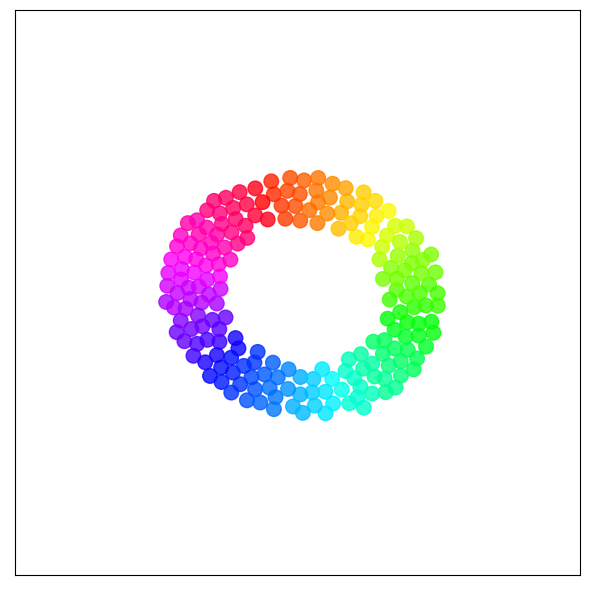

In [12]:
# Set model parameters
N = 200     # number of agents
J = 1.0     # influence of phase on spatial rearrangement
K = 0.0     # phase–phase interaction

ti = 0      # start time
tf = 50     # end time
frames = 100 # number of output time points

# Solve and plot final snapshot
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm, ti, tf, frames, x, y, theta, args=(N, J, K))
plot_swarm(out[0,:,-1], out[1,:,-1], out[2,:,-1]);

The swarmalators quickly arrange to position like phases together! This is often known as the _static phase wave_.

In [ ]:
# Create and display animation
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

If $K$ is positive, we can expect the effects of spatial rearrangement and phase alignment to create a positive feedback loop, which should lead to a uniform phase as we saw in our first example.

However if $K$ is negative, our intuition may not be as clear. Let's slightly perturb $K$ in the negative direction.

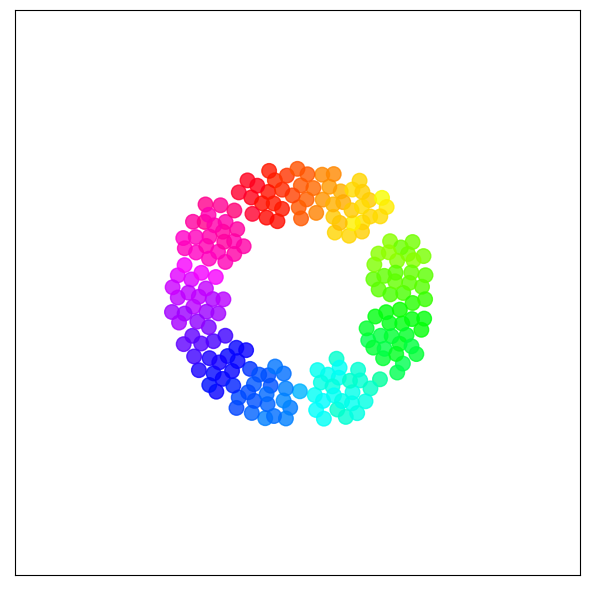

In [13]:
# Set model parameters
N = 200      # number of agents
J = 1.0      # influence of phase on spatial rearrangement
K = -0.1     # phase–phase interaction

ti = 0       # start time
tf = 120     # end time
frames = 240 # number of output time points

# Solve and plot final snapshot
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm, ti, tf, frames, x, y, theta, args=(N, J, K))
plot_swarm(out[0,:,-1], out[1,:,-1], out[2,:,-1]);

This system does not stabilize, but remains in an active state throughout. This is often known as the _splintered phase wave_.

In [ ]:
# Create and display animation
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

In this last example, let us amplify the negative coupling of phases to $K=-0.75$:

In [ ]:
# Set model parameters
N = 200      # number of agents
J = 1.0      # influence of phase on spatial rearrangement
K = -0.75    # phase–phase interaction

ti = 0       # start time
tf = 150     # end time
frames = 300 # number of output time points

# Solve and plot final snapshot
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm, ti, tf, frames, x, y, theta, args=(N, J, K))
plot_swarm(out[0,:,-1], out[1,:,-1], out[2,:,-1]);

This state is often referred to as _active phase wave_.

In [ ]:
# Create and display animation
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

In [ ]:
# Save animation as a gif
ani.save('swarm.gif', writer='pillow', fps=20)

## Adding additional variations

Finally, let us look at an even more generalized version of the Kuramoto model by introducing an external periodic stimulus to simulate forced swarmalators. This example is based on this paper:
>Lizarraga, J. U., & de Aguiar, M. A. Synchronization and spatial patterns in forced swarmalators. Chaos 30, 053112 (2020) https://doi.org/10.1063/1.5141343

We can think of this stimulus as a flashlight to fireflies: fireflies are attracted to its position, and fireflies can also change their lighting patterns to match with the flashlight. We can model this external stimulus as an additional periodic forcing to the phase:
$$
\begin{aligned}
\frac{dx_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{x_j-x_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{x_j-x_i}{r^2_{ij}}\Bigg) \\
\frac{dy_i}{dt} &= \frac{1}{N}\sum_{j\neq{i}}^N\Bigg(\frac{y_j-y_i}{r_{ij}}(1 + J\cos(\theta_j-\theta_i)) - \frac{y_j-y_i}{r_{ij}^2}\Bigg) \\
\frac{d\theta_i}{dt} &= \frac{K}{N}\sum_{j\neq{i}}^N\frac{\sin(\theta_j-\theta_i)}{r_{ij}} + \boxed{F\frac{\cos(\Omega t-\theta_i)}{r_{0i}}}
\end{aligned}
$$
where $F, \Omega, r_{0i}$ represent the amplitude, frequency, and distance to the stimulus. Here we assume the stimulus is placed at the center of the domain $(0,0)$. (It is possible to make the stimulus position as another interactive variable and observe its impact on the synchronization.)

Now let us rewrite our ODE by adding this external forcing.

In [ ]:
@njit
def swarm_force(t, q, N, J, K, F, freq):
    ''' ODE for the Swarmalator system with external forcing on phases.
        Inputs:
            t - the current time
            q - a flattened array of the current x, y, and theta
            N - the number of swarmalators
            J - coupling constant (influence of phase on spatial rearrangement)
            K - coupling constant (phase–phase interaction)
            F - amplitude of external forcing stimulus
            freq - frequency of external forcing stimulus
        Outputs:
            dq - a flattened array of first derivatives of x, y, and theta
    '''
    # Unpack the x-coordinates, y-coordinates, and phases
    x, y, theta = q[:N], q[N:2*N], q[2*N:]

    # Set up arrays to store the derivatives
    dx, dy, dtheta = np.zeros(N), np.zeros(N), np.zeros(N)

    for i in range(N):
        for j in range(N):
            if j != i:
                # Compute recurring quantities for easy reuse
                xij = x[j] - x[i]                    # x_i - x_i
                yij = y[j] - y[i]                    # y_j - y_i
                tij = theta[j] - theta[i]            # theta_j - theta_i
                rij = np.sqrt(xij*xij + yij*yij)     # r_ij (distance between agents)
                r0i = np.sqrt(x[i]*x[i] + y[i]*y[i]) # r_0i (distance to stimulus)

                # Spatial attraction (x and y components)
                x_att = xij/rij * (1. + J*np.cos(tij))
                y_att = yij/rij * (1. + J*np.cos(tij))

                # Spatial repulsion (x and y components)
                x_rep = -xij/(rij*rij)
                y_rep = -yij/(rij*rij)

                # Phase coupling with external forcing
                tcouple = K * np.sin(tij)/rij
                force = F * np.cos(freq*t-theta[i])/r0i

                # Add contribution to the derivative arrays
                dx[i] += x_att + x_rep
                dy[i] += y_att + y_rep
                dtheta[i] += tcouple + force

    # Define the first derivative and normalize by the number of agents
    # Note: np.hstack is slower with njit
    dq = np.zeros(3*N)
    dq[:N], dq[N:2*N], dq[-N:] = dx/float(N), dy/float(N), dtheta/float(N)
    return dq

Let us test our new Swarmalator model!

In [ ]:
# Set model parameters
N = 200           # number of agents
J = 1.0           # influence of phase on spatial rearrangement
K = -0.1          # phase–phase interaction
F = 1.0           # amplitude of external stimulus
freq = 3./2*np.pi # frequency of external stimulus

ti = 0            # start time
tf = 100          # end time
frames = 100      # number of output time points

# Solve and plot animation
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm_force, ti, tf, frames, x, y, theta, args=(N, J, K, F, freq))
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

In the reference paper, authors have categorized the $(J,K)$ combinations into five states with some reference values:

| static synchrony | static asynchrony | static phase wave | splintered phase wave | active phase wave |
|:----------------:|:-----------------:|:-----------------:|:---------------------:|:-----------------:|
|    $(0.1,1)$    |     $(0.1,-1)$     |      $(1,0)$      |       $(1,-0.1)$      |    $(1,-0.75)$    |
 
Below is a collage of patterns formed by $250$ swarmalators under external stimulus $F=1$ placed at the center at the five representative states.

![swarm_force_speed.gif](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/swarmalator_force_speedup.gif)

Play around with the $F$ values and see what patterns you could generate!

We can also make $F$ time-dependent by setting the $F$ value to be linearly increasing with respect to (w.r.t.) time. The example below uses `swarm_force_time` as the ODE, where we manually set the $F$ to increase from $0$ to $4$.

In [ ]:
@njit
def swarm_force_time(t, q, N, J, K, F, freq):
    ''' ODE for the Swarmalator system with time-dependent external forcing on phases.
        Inputs:
            t - the current time
            q - a flattened array of the current x, y, and theta
            N - the number of swarmalators
            J - coupling constant (influence of phase on spatial rearrangement)
            K - coupling constant (phase–phase interaction)
            F - amplitude of external forcing stimulus
            freq - frequency of external forcing stimulus
        Outputs:
            dq - a flattened array of first derivatives of x, y, and theta
    '''
    # Unpack the x-coordinates, y-coordinates, and phases
    x, y, theta = q[:N], q[N:2*N], q[2*N:]

    # Set up arrays to store the derivatives
    dx, dy, dtheta = np.zeros(N), np.zeros(N), np.zeros(N)

    # Set time-dependent force
    # Hard-code, should use a more general definition
    F = t / 100

    for i in range(N):
        for j in range(N):
            if j != i:
                # Compute recurring quantities for easy reuse
                xij = x[j] - x[i]                    # x_i - x_i
                yij = y[j] - y[i]                    # y_j - y_i
                tij = theta[j] - theta[i]            # theta_j - theta_i
                rij = np.sqrt(xij*xij + yij*yij)     # r_ij (distance between agents)
                r0i = np.sqrt(x[i]*x[i] + y[i]*y[i]) # r_0i (distance to stimulus)

                # Spatial attraction (x and y components)
                x_att = xij/rij * (1. + J*np.cos(tij))
                y_att = yij/rij * (1. + J*np.cos(tij))

                # Spatial repulsion (x and y components)
                x_rep = -xij/(rij*rij)
                y_rep = -yij/(rij*rij)

                # Phase coupling with external forcing
                tcouple = K * np.sin(tij)/rij
                force = F * np.cos(freq*t-theta[i])/r0i

                # Add contribution to the derivative arrays
                dx[i] += x_att + x_rep
                dy[i] += y_att + y_rep
                dtheta[i] += tcouple + force

    # Define the first derivative and normalize by the number of agents
    # Note: np.hstack is slower with njit
    dq = np.zeros(3*N)
    dq[:N], dq[N:2*N], dq[-N:] = dx/float(N), dy/float(N), dtheta/float(N)
    return dq

> Note: The following cell will take a VERY LONG time (about 4 minutes) to run!

In [ ]:
# Set model parameters
N = 200           # number of agents
J = 1.0           # influence of phase on spatial rearrangement
K = -0.1          # phase–phase interaction
F = 1.0           # amplitude of external stimulus
freq = 3./2*np.pi # frequency of external stimulus

ti = 0            # start time
tf = 400          # end time
frames = 400      # number of output time points

# Solve and plot animation
x, y, theta = init_swarm(N, seed=12)
out = solve_swarm(swarm_force_time, ti, tf, frames, x, y, theta, args=(N, J, K, F, freq))
ani = animate_swarm(out, colormap='hsv')
HTML(ani.to_html5_video())

## The final touch

Let us put everything together! We use an interactive widget to switch between the five states, enable external forcing, changing forcing values, and visualize the trails of swarmalators!

We have provided a helper function to visualize the trails of swarmalators in `oscillators_utils.py`.

In [ ]:
# Run the cell if you are running the notebook on Google Colab
!git clone https://github.com/yue-sun/generative-art.git
%cd generative-art/03_wednesday

In [ ]:
from oscillators_utils import animate_swarm_trail

force_slider = widgets.FloatSlider(
    value=1.0, min=0.0, max=5.0, step=0.1,
    description='force:', readout_format='.1f',)
@widgets.interact_manual(states = ['static_synchrony', 'static_asynchrony','static_phase_wave', 'splintered_phase_wave', 'active_phase_wave'],
                         trail = ['True', 'False'], F = force_slider, force_time = ['True', 'False'])
def interactive_menu_plot(states='splintered_phase_wave', trail='True', F=1.0, force_time='True'):
    h = display(display_id=True)
    
    # Reference states J and K values
    static_synchrony      = [0.1,   1.0]
    static_asynchrony     = [0.1,  -1.0]
    static_phase_wave     = [1.0,   0.0]
    splintered_phase_wave = [1.0,  -0.1]
    active_phase_wave     = [1.0, -0.75]
    
    # Get parameters
    J, K = eval(states)

    # Set model parameters
    N = 200           # number of agents
    freq = 3./2*np.pi # frequency of external stimulus

    ti = 0            # start time
    tf = 200          # end time
    frames = 400      # number of output time points
    ntrail = 30       # length of trail

    # Solve and plot animation
    x, y, theta = init_swarm(N, seed=12)
    print('running simulation...')
    if eval(force_time):
        out = solve_swarm(swarm_force_time, ti, tf, frames, x, y, theta, args=(N, J, K, F, freq))
    else:
        out = solve_swarm(swarm_force, ti, tf, frames, x, y, theta, args=(N, J, K, F, freq))

    # Create and display animation
    print('creating animation...')
    if eval(trail):
        ani = animate_swarm_trail(out, ntrail, colormap='hsv')
    else:
        ani = animate_swarm(out, colormap='hsv')
    h.display(HTML(ani.to_html5_video()))

There are a few additional changes you could try:
- add velocity and angular velocity for individual swarmalators, i.e. $u_i, v_i, \omega_i\neq0$
- change the position of the stimulus w.r.t. time
- change the time-dependent forcing rhythm (i.e. not linearly increasing amplitude)